In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sensormotion as sm
import pandas as pd

In [2]:
plt.rcParams["figure.figsize"] = (15,5)

In [3]:
df = pd.read_csv("data2.csv")
df.head()

,Packet number,Gyroscope X (deg/s),Gyroscope Y (deg/s),Gyroscope Z (deg/s),Accelerometer X (g),Accelerometer Y (g),Accelerometer Z (g),Magnetometer X (G),Magnetometer Y (G),Magnetometer Z (G)
0,3,-0.0625,-0.2500,-0.0625,-0.015137,0.030762,0.971191,0.026855,0.025879,-0.323730
1,5,-0.0625,-0.2500,-0.0625,-0.015137,0.030762,0.971191,0.026855,0.025879,-0.323730
2,6,-0.0625,0.0625,0.0000,-0.046387,0.026855,0.967285,0.038574,0.025879,-0.322266
3,8,-0.3750,-0.2500,-0.3750,-0.046387,0.022949,0.979004,0.038574,0.025879,-0.322266
4,9,-0.0625,0.5625,0.0625,-0.050293,0.042480,0.971191,0.038574,0.025879,-0.322266


In [4]:
df = df.loc[2150:6250 ,:]
df.shape

(4101, 10)

In [10]:
sampling_rate = 512  # number of samples per second
seconds = 8.01
time = np.arange(0, seconds*sampling_rate) * 10  # times in milliseconds
time = time[:-1]
len(time)

4101

In [11]:
x = df['Accelerometer X (g)']
y = df['Accelerometer Y (g)']
z = df['Accelerometer Z (g)']

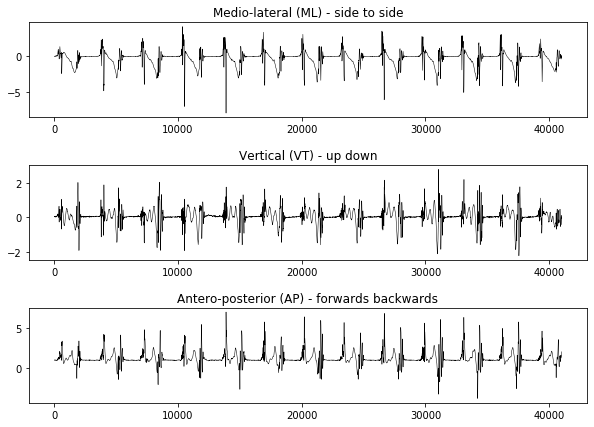

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,7))

ax[0].set_title('Medio-lateral (ML) - side to side')
ax[0].plot(time, x, linewidth=0.5, color='k')

ax[1].set_title('Vertical (VT) - up down')
ax[1].plot(time, y, linewidth=0.5, color='k')

ax[2].set_title('Antero-posterior (AP) - forwards backwards')
ax[2].plot(time, z, linewidth=0.5, color='k')

fig.subplots_adjust(hspace=.5)

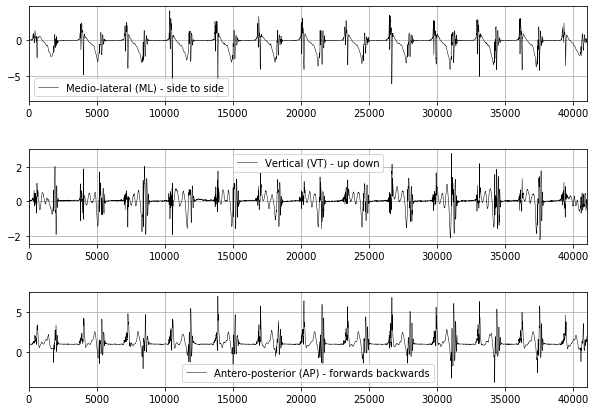

In [14]:
sm.plot.plot_signal(time, [{'data': x, 'label': 'Medio-lateral (ML) - side to side', 'line_width': 0.5},
                           {'data': y, 'label': 'Vertical (VT) - up down', 'line_width': 0.5},
                           {'data': z, 'label': 'Antero-posterior (AP) - forwards backwards', 'line_width': 0.5}],
                    subplots=True, fig_size=(10,7))

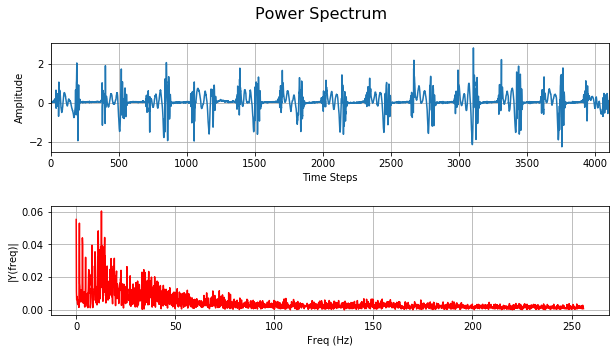

In [15]:
_ = sm.signal.fft(y, sampling_rate, plot=True)

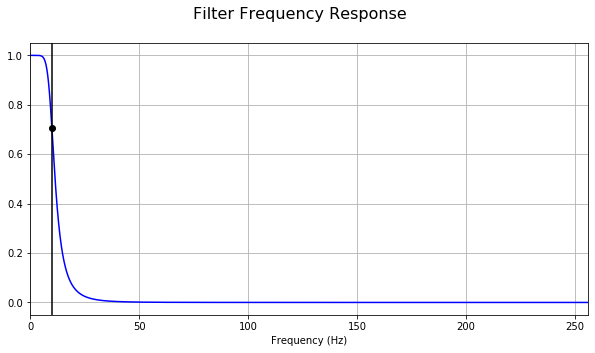

In [16]:
sm.plot.plot_filter_response(10, sampling_rate, 'low', filter_order=4)

In [17]:
# Build the filter
b, a = sm.signal.build_filter(10, sampling_rate, 'low', filter_order=4)

# Filter signals
x_f = sm.signal.filter_signal(b, a, x)  # ML medio-lateral
y_f = sm.signal.filter_signal(b, a, y)  # VT vertical
z_f = sm.signal.filter_signal(b, a, z)  # AP antero-posterior

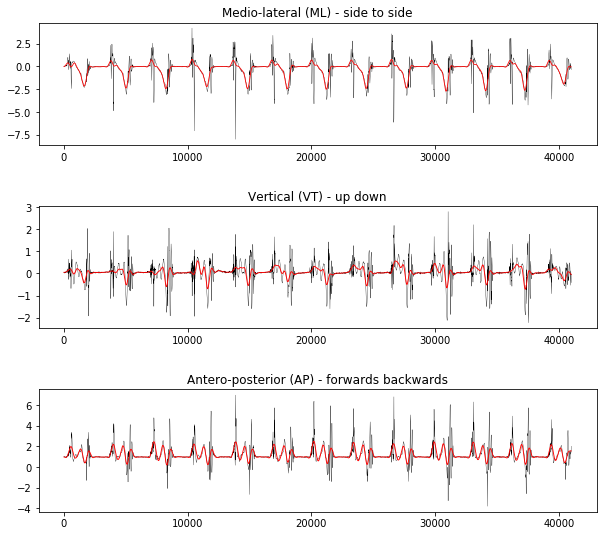

In [18]:
# Create plots with overlaid filtered signals (in red)
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,9))

ax[0].set_title('Medio-lateral (ML) - side to side')
ax[0].plot(time, x, linewidth=0.3, color='k')
ax[0].plot(time, x_f, linewidth=0.8, color='r')

ax[1].set_title('Vertical (VT) - up down')
ax[1].plot(time, y, linewidth=0.3, color='k')
ax[1].plot(time, y_f, linewidth=0.9, color='r')

ax[2].set_title('Antero-posterior (AP) - forwards backwards')
ax[2].plot(time, z, linewidth=0.3, color='k')
ax[2].plot(time, z_f, linewidth=0.9, color='r')

fig.subplots_adjust(hspace=.5)

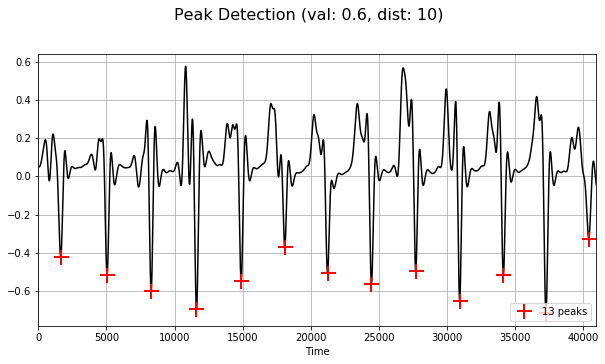

In [20]:
peak_times, peak_values = sm.peak.find_peaks(time, y_f, peak_type='valley', min_val=0.6, min_dist=10, plot=True)

In [21]:
step_count = sm.gait.step_count(peak_times)
cadence = sm.gait.cadence(time, peak_times)
step_time, step_time_sd, step_time_cov = sm.gait.step_time(peak_times)

print(' - Number of steps: {}'.format(step_count))
print(' - Cadence: {:.2f} steps/min'.format(cadence))
print(' - Mean step time: {:.2f}ms'.format(step_time))
print(' - Step time variability (standard deviation): {:.2f}'.format(step_time_sd))
print(' - Step time variability (coefficient of variation): {:.2f}'.format(step_time_cov))

 - Number of steps: 13
 - Cadence: 19.02 steps/min
 - Mean step time: 3232.50ms
 - Step time variability (standard deviation): 75.73
 - Step time variability (coefficient of variation): 0.02


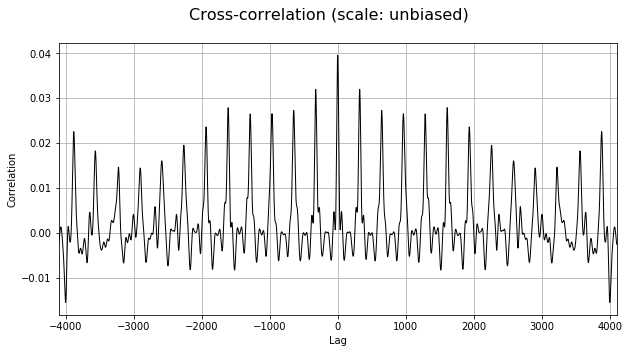

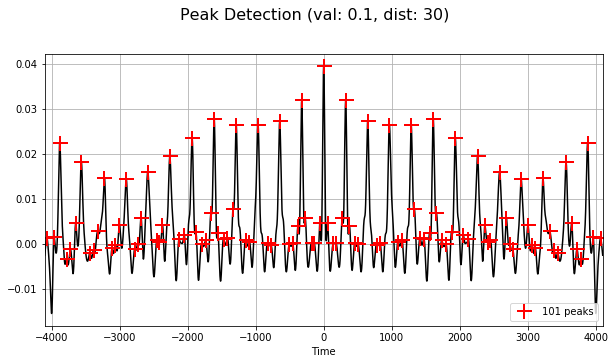

 - Step regularity: 0.1202
 - Stride regularity: 0.0057
 - Step symmetry: 0.0475


In [22]:
ac, ac_lags = sm.signal.xcorr(y_f, y_f, scale='unbiased', plot=True)

ac_peak_times, ac_peak_values = sm.peak.find_peaks(ac_lags, ac, peak_type='peak', min_val=0.1, min_dist=30, plot=True)

step_reg, stride_reg = sm.gait.step_regularity(ac_peak_values)
step_sym = sm.gait.step_symmetry(ac_peak_values)

print(' - Step regularity: {:.4f}'.format(step_reg))
print(' - Stride regularity: {:.4f}'.format(stride_reg))
print(' - Step symmetry: {:.4f}'.format(step_sym))